# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [401]:
import os, sys, wave, struct,time

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [402]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [403]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [404]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [405]:
play = False
if play :
    play_sound(sound) 

In [406]:
wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [407]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

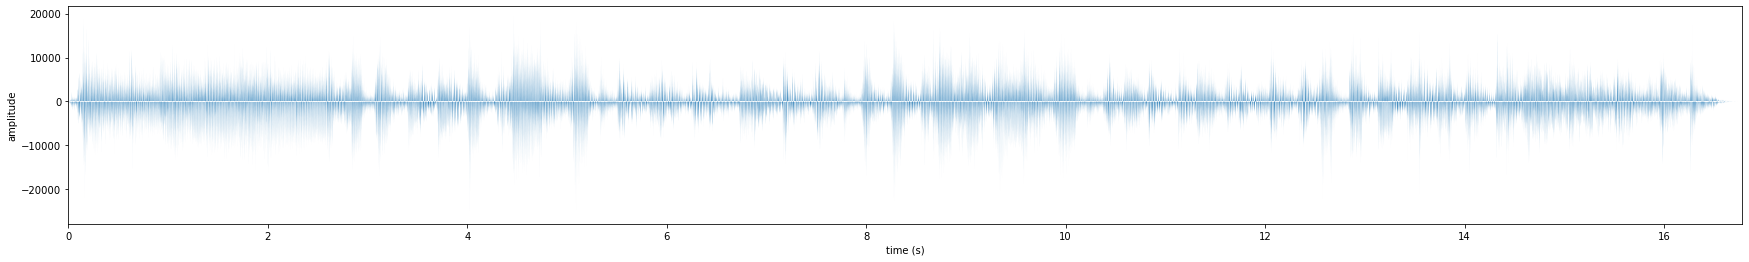

In [408]:
plot_sound(x, times)

In [409]:
write('Copy.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

# Conversion of sampling rate

## Q1 : Generate low-pass filter with Remez Method

source : https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html

In [410]:
from scipy import signal

fs = 48000       # Sample rate, Hz

cutoff = 8000    # Desired cutoff frequency, Hz

trans_width = 200  # Width of transition from pass band to stop band, Hz

numtaps = 800     # Size of the FIR filter.

h = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)



### Personal implementation of impulse response of h


In [411]:
def TZ(h):
    def H(z) : 
        rep = 0
        for k in range(h.size):

            rep += h[k]*(z**(-k)) 
        return rep
    return H

#Y = [20*np.log10(abs(TZ(h)(np.exp(2*3.14*1j*(freq/48000))))) for freq in range(24000)]
#X = [k for k in range(24000)]

#plt.plot(X,Y)


### Our methode is very slow let's use the numpy implementation

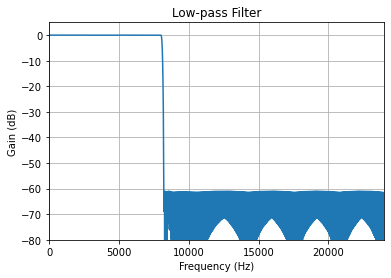

In [412]:
def plot_response(fs, w, h, title):

    "Utility function to plot response functions"

    fig = plt.figure()

    ax = fig.add_subplot(111)

    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))

    ax.set_ylim(-80, 5)

    ax.set_xlim(0, 0.5*fs)

    ax.grid(True)

    ax.set_xlabel('Frequency (Hz)')

    ax.set_ylabel('Gain (dB)')

    ax.set_title(title)

w, x = signal.freqz(h, [1], worN=2000) #Compute the frequency response of a digital filter.

plot_response(fs, w, x, "Low-pass Filter")

With our parameters we respect the 50db difference

## Q2 : Simple digital chain of this Conversion

We will follow the chain that we saw in the Tutorial on the conversion of sampling rate.

### First - Load the file :

In [413]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


### Second - Upsampling with factor 2 :

In [414]:
up = np.zeros(2*len(x),dtype = np.int64)
for i in range(len(up)):
    if i%2 == 0 :
        up[i] = x[i//2]

### Third - Filtering with our generated Low-Pass filter

In [415]:
out = signal.lfilter(h,1,up)

### Fourth : Downsampling with factor 3

In [416]:
down = np.zeros(len(out)//3)

for i in range(len(down)):
        down[i] = out[3*i]

### Let's do them all in the same time :

In [417]:
a=time.time()

up = np.zeros(2*len(x),dtype = np.int64)
for i in range(len(up)):
    if i%2 == 0 :
        up[i] = x[i//2]
out = signal.lfilter(h,1,up)
down = np.zeros(len(out)//3)

for i in range(len(down)):
        down[i] = out[3*i]

print(time.time()-a)

0.39107537269592285


### Testing the output file

In [418]:
write('Downsampled.wav', 32000, np.array(down)) # to write a new wave file

In [419]:
timestep = 1/float(32000)
times = np.arange(len(down))*timestep

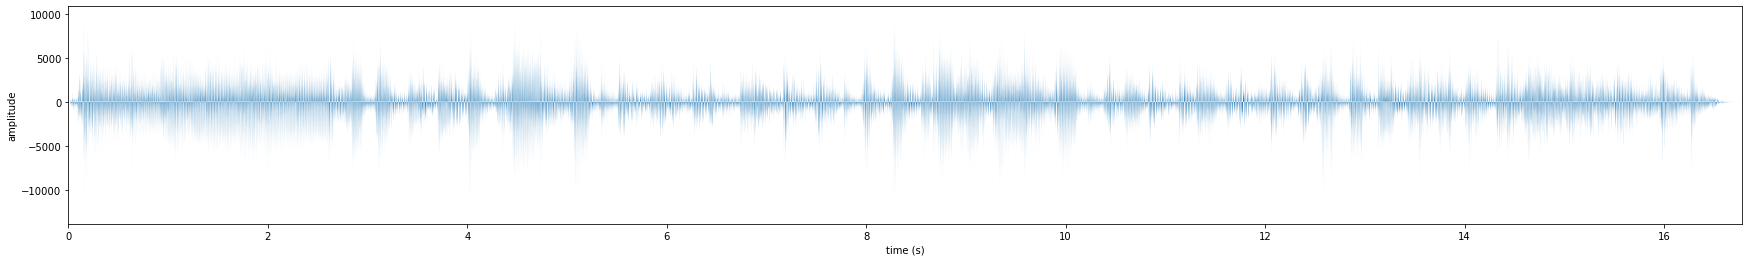

In [420]:
plot_sound(down, times)

## Q3 : Programation of the efficient implementation

We will use the chain on the tutorial

### We program the differents filters we need :

In [421]:
R0 = [ h[i] for i in range(len(h)) if i%2==0 ]
R1 = [ h[i] for i in range(len(h)) if i%2==1 ]

ZR0 = np.zeros(len(R0)+1)
ZR0[1:] = R0
print(ZR0)


EZR00 = [ ZR0[i] for i in range(len(ZR0)) if i%3==0 ]
EZR01 = [ ZR0[i] for i in range(len(ZR0)) if i%3==1 ]
EZR02 = [ ZR0[i] for i in range(len(ZR0)) if i%3==2 ]

ER10 = [ R1[i] for i in range(len(R1)) if i%3==0 ]
ER11 = [ R1[i] for i in range(len(R1)) if i%3==1 ]
ER12 = [ R1[i] for i in range(len(R1)) if i%3==2 ]



[ 0.00000000e+00  8.23107488e-06  1.41334496e-05 -4.73433763e-05
  2.85095563e-05  2.11599872e-05 -5.41714604e-05  3.63637680e-05
  1.99124329e-05 -6.11839468e-05  4.53428590e-05  1.75640400e-05
 -6.81637429e-05  5.55031118e-05  1.38470789e-05 -7.49183821e-05
  6.68389875e-05  8.76973827e-06 -8.15089453e-05  7.92815582e-05
  2.46452737e-06 -8.77859051e-05  9.28971654e-05 -6.35235791e-06
 -9.28548963e-05  1.07493842e-04 -1.65332233e-05 -9.76282984e-05
  1.23231868e-04 -2.85749634e-05 -1.00869950e-04  1.39805296e-04
 -4.29972799e-05 -1.02719943e-04  1.57071655e-04 -5.96762531e-05
 -1.02862402e-04  1.74773125e-04 -7.86288968e-05 -1.01020839e-04
  1.92816637e-04 -1.00103322e-04 -9.68867012e-05  2.10937023e-04
 -1.23889355e-04 -9.01259659e-05  2.28795322e-04 -1.50288096e-04
 -8.04517264e-05  2.46087963e-04 -1.79036421e-04 -6.77362690e-05
  2.62415165e-04 -2.10144886e-04 -5.13973584e-05  2.77480574e-04
 -2.43484009e-04 -3.13055784e-05  2.90844824e-04 -2.78909167e-04
 -7.22527395e-06  3.02050

### We program the efficient implementation

In [422]:
a= time.time()
x03 = [ x[3*i] for i in range(len(x)//3)]
x13 = [ x[3*i + 1] for i in range(len(x)//3)]
x23 = [ x[3*i + 2] for i in range(len(x)//3)]


out1 = signal.lfilter(EZR00,1,x03) + signal.lfilter(EZR01,1,x13) + signal.lfilter(EZR02,1,x23)
out2 = signal.lfilter(ER10,1,x03) + signal.lfilter(ER11,1,x13) + signal.lfilter(ER12,1,x23)


out = np.zeros(len(out1)+len(out2))
for i in range(len(out)):
    if i%2==0 : out[i] = out1[i//2]
    else : out[i] = out2[(i-1)//2]

print(time.time()-a)


0.25352025032043457


## Q4 : We can see that the output is returned faster !

### We can test the output

In [423]:
write('efficient.wav', 32000, np.array(out, dtype=np.int16)) # to write a new wave file

Listen to the file

In [424]:
data_path = os.getcwd()
filename = 'efficient.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=537154, comptype='NONE', compname='not compressed')


View it :

In [425]:
wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
v = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=537154, comptype='NONE', compname='not compressed')


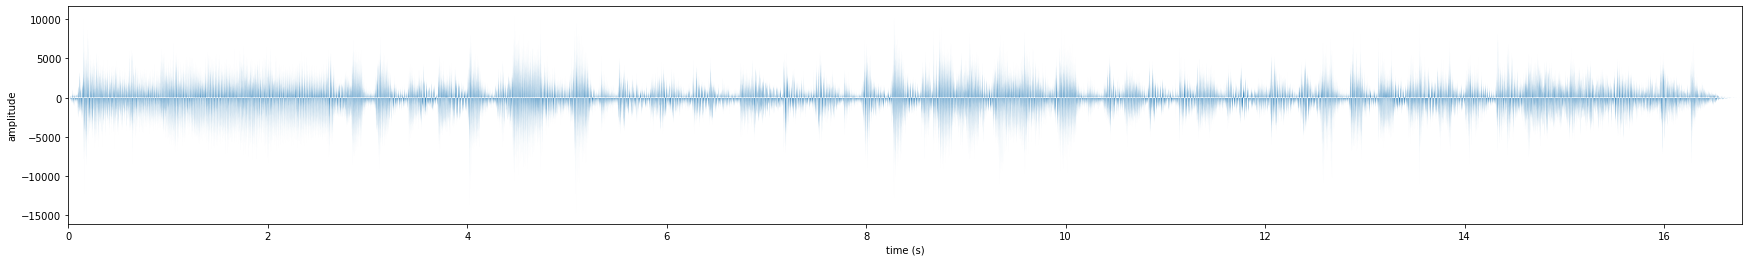

In [426]:
timestep = 1/float(Fs)
times = np.arange(len(v))*timestep
plot_sound(v, times)

# Signal analysis with the STFT

## Parameters

In [427]:


N = x.shape[0] # % longueur du signal
M = 512 # ordre de la tfd
Nw = M-1
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
L = M//2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse
Fs = 48000 

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

## Q1 : DFT of Hanning window

/tmp/ipykernel_4938/2035001892.py:7: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(mag)


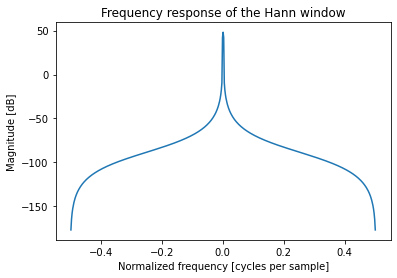

In [428]:
from numpy.fft import fft, fftshift

A = fft(w,M)
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))

response = 20 * np.log10(mag)
plt.plot(freq, response)
plt.title("Frequency response of the Hann window")

plt.ylabel("Magnitude [dB]")
(0, 0.5, 'Magnitude [dB]')
plt.xlabel("Normalized frequency [cycles per sample]")
plt.axis('tight')
plt.show()


## Q2 : Our STFT uses the band-pass convention

In [429]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]


### Plot STFT

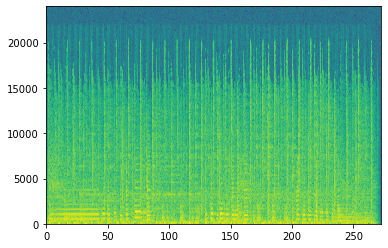

In [430]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

    

## Q3 : Program x3 and analyse it

### Parameters

In [431]:
N = x.shape[0] # % longueur du signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = 1 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 32 # ordre de la tfd
L = M//2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    X_tilde = np.zeros((M,Nt),dtype=complex)

### Plot Hanning windows

/tmp/ipykernel_4938/2035001892.py:7: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(mag)


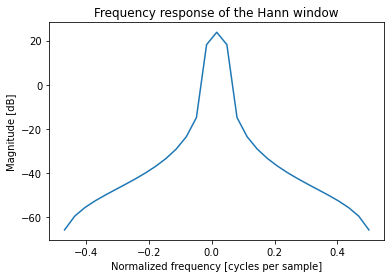

In [432]:
from numpy.fft import fft, fftshift

A = fft(w,M)
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))

response = 20 * np.log10(mag)
plt.plot(freq, response)
plt.title("Frequency response of the Hann window")

plt.ylabel("Magnitude [dB]")
(0, 0.5, 'Magnitude [dB]')
plt.xlabel("Normalized frequency [cycles per sample]")
plt.axis('tight')
plt.show()


### Plot the STFT

In [433]:
X_tilde = np.zeros((M, Nt), dtype=complex)
for u in np.arange(0, Nt).reshape(-1):
    tram = np.multiply(x[np.arange(int(u*R+1), int(u*R+1+Nw))], w)
    X_tilde[:, u] = np.fft.fft(tram, M)

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

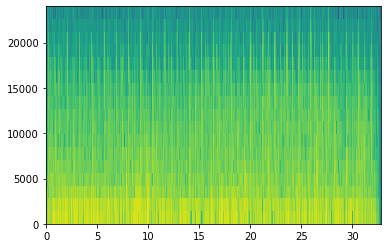

In [434]:
if affich:
    plt.imshow(20*np.log10(np.abs(X_tilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])

### Extract x3

In [435]:
x3 = X_tilde[3,:]
x3


array([ 0.16838493+2.70313201j, -1.4026379 +2.57481387j,
       -2.66820324+1.56657199j, ...,  0.34246309+0.71102348j,
       -0.0704793 +0.95651507j, -0.64456602+0.90614836j])

x3 is therefore complex

### Visualize the real part of x3

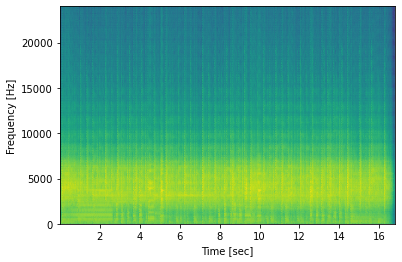

In [436]:
rX3 = np.real(x3)

f, t, Sxx = signal.spectrogram(rX3, fs)

plt.pcolormesh(t, f, 20*np.log10(np.abs(Sxx)), shading='gouraud')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()


In [437]:
write('rx3.wav', 48000, np.array(rX3, dtype=np.int16)) # to write a new wave file

In [438]:
data_path = os.getcwd()
filename = 'rx3.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805701, comptype='NONE', compname='not compressed')


### Analyse the effect of the extraction

We can see that the effect of the extractions is like a pass-band in the frequency 4500 which is (3/32)*48000. Let's try it out !

Text(0, 0.5, 'Frequency (Hz)')

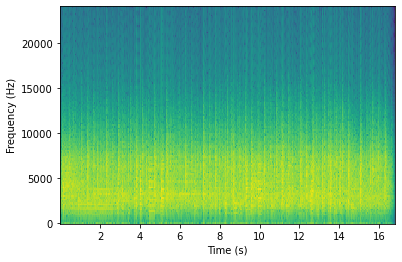

In [439]:
f_cible = 4500

b, a = signal.butter(5, [f_cible-2500, f_cible+2500], btype="band",fs = 48000)

X_filter = signal.lfilter(b, a, x)

f, t, Sxx = signal.spectrogram(X_filter, Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# Overlap-add reconstruction

## Load File

In [440]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


## Parameters

In [441]:
N = x.shape[0] # % longueur du signal
M = 200 
Nw = M-1
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw//4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
# ordre de la tfd
L = M//2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse 

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

X_tilde = np.zeros((M, Nt), dtype=complex)
for u in np.arange(0, Nt).reshape(-1):
    tram = np.multiply(x[np.arange(int(u*R+1), int(u*R+1+Nw))], w)
    X_tilde[:, u] = np.fft.fft(tram, M)



## Functions

In [442]:
def ola(w = None,hop = None,Nb = 500): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    print(w.shape)
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1))
    output.shape # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N

        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    return output

## Q4 : Perfect reconstruction check

In [443]:
h = np.hanning(200)/1.22

h2 = np.multiply(h,h)

f = ola(h2,200//4)

print(f[10000])


(200, 1)
[1.00251193]


Plotting of f :

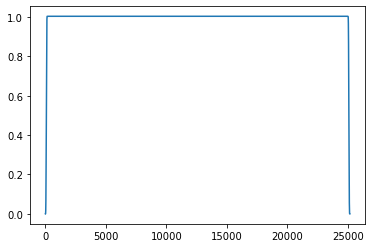

In [444]:
plt.plot(range(f.size),f)
plt.show()

## Q5 : Reconstruction of Signal

In [445]:
Ys = np.zeros(Xtilde.shape)

for u in range(Xtilde.shape[1]):

    Ys[:,u] = np.multiply(np.fft.ifft(X_tilde[:,u],M),h)

Ys.shape

out = np.zeros(Nw + R *Ys.shape[1])

for k in np.arange(0,Ys.shape[1]).reshape(-1):
    deb = k* R
    fin = deb + Nw + 1

    out[np.arange(deb,fin)] = out[np.arange(deb,fin)] + Ys[:,k] # OLA


/tmp/ipykernel_4938/335329559.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  Ys[:,u] = np.multiply(np.fft.ifft(X_tilde[:,u],M),h)


### Testing :

In [446]:
write('Reconstruction.wav', 48000, np.array(out, dtype=np.int16)) # to write a new wave file

Listen to the file :

In [447]:
data_path = os.getcwd()
filename = 'Reconstruction.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


View it :

In [448]:
wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
V = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


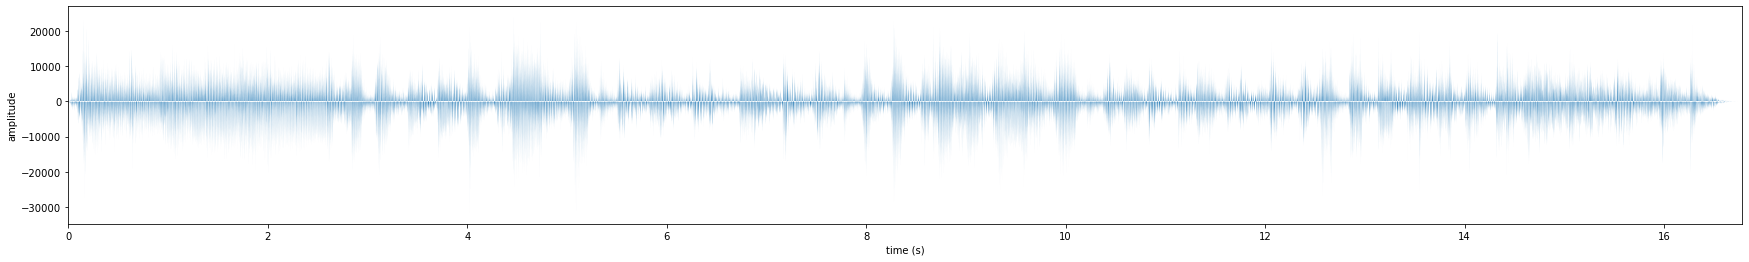

In [449]:
timestep = 1/float(Fs)
times = np.arange(len(V))*timestep
plot_sound(V, times)

Text(0, 0.5, 'Frequency (Hz)')

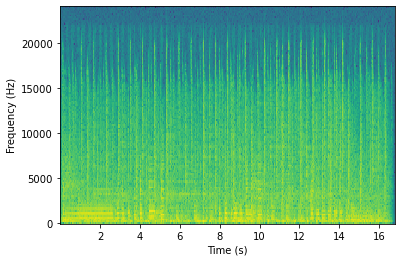

In [450]:
f, t, Sxx = signal.spectrogram(V, Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

# STFT audio equalizer

A real frequency is a combinaison of frequency of order k and m-k (for k>0) and 0

## Q6 : Equalizer implementation

In [451]:
def generate_equalizer (array) : # insert array with M//2 + 1 values
    m = array.size
    w = np.zeros((m-1)*2)
    w[0] = array[0]
    for i in range(1,m) : 
        w[i] = array[i]
        w[m-i]= array[i]

    return w

### Perfect reconstruction

In [452]:
w = generate_equalizer(np.ones(M//2 +1))

Ys = np.zeros(Xtilde.shape)

for u in range(Xtilde.shape[1]):

    Ys[:,u] = np.multiply(np.fft.ifft(np.multiply(w,X_tilde[:,u]),M),h)

Ys.shape

out = np.zeros(Nw + R *Ys.shape[1])

for k in np.arange(0,Ys.shape[1]).reshape(-1):
    deb = k* R
    fin = deb + Nw + 1

    out[np.arange(deb,fin)] = out[np.arange(deb,fin)] + Ys[:,k] # OLA



/tmp/ipykernel_4938/3931267129.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  Ys[:,u] = np.multiply(np.fft.ifft(np.multiply(w,X_tilde[:,u]),M),h)


#### Test output 

In [453]:
write('equalizer-perfect-reconstruction.wav', 48000, np.array(out, dtype=np.int16)) # to write a new wave file

Listen to file :

In [454]:
data_path = os.getcwd()
filename = 'equalizer-perfect-reconstruction.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


View :

In [455]:
wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
E = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


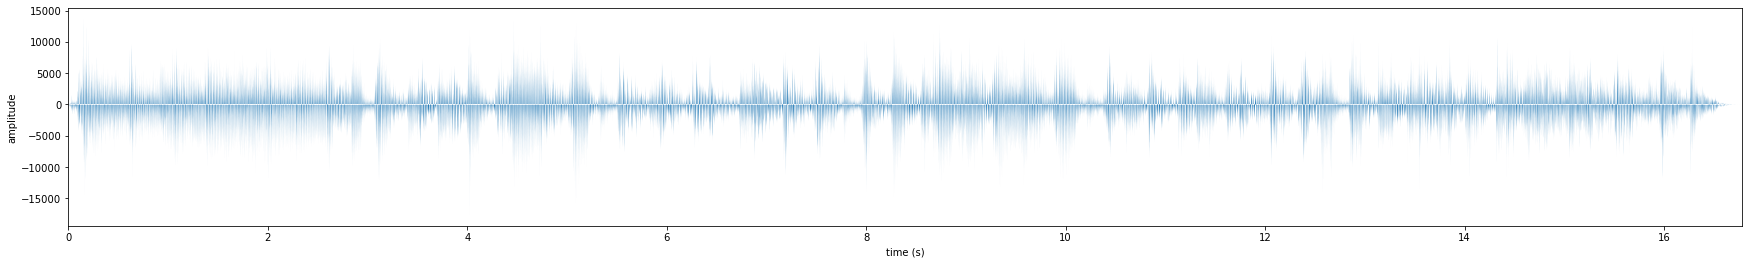

In [456]:
timestep = 1/float(Fs)
times = np.arange(len(E))*timestep
plot_sound(E, times)

/tmp/ipykernel_4938/1501003494.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 20*np.log10(Sxx))


Text(0, 0.5, 'Frequency (Hz)')

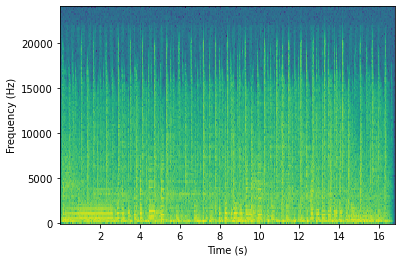

In [457]:
f, t, Sxx = signal.spectrogram(E, Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

#### Passe-bas avec Equalizer

In [458]:
y = np.zeros(M//2 + 1)
for i in range(10) : 
    y[i] = 1

In [459]:
w = generate_equalizer(y)

Ys = np.zeros(Xtilde.shape)

for u in range(Xtilde.shape[1]):

    Ys[:,u] = np.multiply(np.fft.ifft(np.multiply(w,X_tilde[:,u]),M),h)

Ys.shape

out = np.zeros(Nw + R *Ys.shape[1])

for k in np.arange(0,Ys.shape[1]).reshape(-1):
    deb = k* R
    fin = deb + Nw + 1

    out[np.arange(deb,fin)] = out[np.arange(deb,fin)] + Ys[:,k] # OLA


/tmp/ipykernel_4938/3065039704.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  Ys[:,u] = np.multiply(np.fft.ifft(np.multiply(w,X_tilde[:,u]),M),h)


#### Test output

In [460]:
write('low-eq.wav', 48000, np.array(out, dtype=np.int16)) # to write a new wave file

Listen to file

In [461]:
data_path = os.getcwd()
filename = 'low-eq.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


View :

In [462]:
wavefile = load_sound(sound)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
L = np.array(data)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805710, comptype='NONE', compname='not compressed')


/tmp/ipykernel_4938/3842511182.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 20*np.log10(Sxx))


Text(0, 0.5, 'Frequency (Hz)')

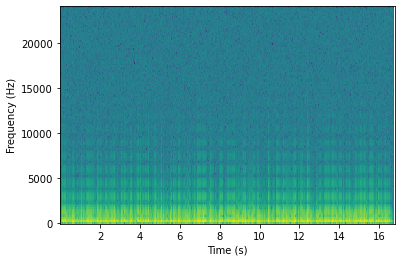

In [463]:
f, t, Sxx = signal.spectrogram(L, Fs)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')